## 1.Import Modul
    
         
    

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import sys
from tools import tools
from tools import  pipeline as p
from tools import  sar
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit    
import bz2
from glob import glob
import _pickle as cPickle
import pickle
# The next two lines are for optical reasons only. They can be safely disabled.
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18




## 2. Load sdf file 


In [4]:
file = "E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/data/train_set_toxic.sdf"
sdfInfo = dict(smilesName='SMILES',molColName='ROMol')
moldf = PandasTools.LoadSDF(file,**sdfInfo)
print(moldf.shape)
#Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
#duplicatas by smiles
moldf = moldf.drop_duplicates(subset=['SMILES'])
#logP
#moldf['logP'] = moldf['Mol'].apply(MolLogP)
#Remove moléculas sem esrtutura no RDKit
moldf = moldf[pd.notnull(moldf['Mol'])]
print(moldf.shape)
#Colunas no pandas
moldf.keys()

Failed to patch pandas - unable to change molecule rendering


(541, 12)
(541, 12)


Index(['id', 'casrn', 'smiles (First)', 'Molecular weight', 'name', 'Outcome',
       'Molecule (RDKit Mol) (InChI Code)', 'reference', 'molecule_form', 'ID',
       'SMILES', 'Mol'],
      dtype='object')

In [5]:
moldf

,id,casrn,smiles (First),Molecular weight,name,Outcome,Molecule (RDKit Mol) (InChI Code),reference,molecule_form,ID,SMILES,Mol
0,923,38640-62-9,,212.3300018310547,"1,2-bis(propan-2-yl)naphthalene",0,InChI=1S/C16H20/c1-11(2)13-7-5-10-16-14(12(3)4...,ECHA,A,,CC(C)c1cccc2c(C(C)C)cccc12,<rdkit.Chem.rdchem.Mol object at 0x0000021C601...
1,3244; 3245,592-41-6,,84.15948486328125,hex-1-ene,0,"InChI=1S/C6H12/c1-3-5-6-4-2/h3H,1,4-6H2,2H3",ECHA,V,,C=CCCCC,<rdkit.Chem.rdchem.Mol object at 0x0000021C601...
2,1143,2909-38-8,,153.56576538085938,1-chloro-3-isocyanatobenzene,1,InChI=1S/C7H4ClNO/c8-6-2-1-3-7(4-6)9-5-10/h1-4H,ECHA,V,,O=C=Nc1cccc(Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x0000021C600...
3,220768; 901830,1241-94-7,CCCCC(CC)CO[P](=O)(Oc1ccccc1)Oc2ccccc2,362.3997497558594,2-Ethylhexyl diphenyl phosphate,1,InChI=1S/C20H27O4P/c1-3-5-12-18(4-2)17-22-25(2...,ToxValDB,not specified,,CCCCC(CC)COP(=O)(Oc1ccccc1)Oc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x0000021C600...
4,3459,2935-90-2,,120.17012023925781,methyl 3-sulfanylpropanoate,1,"InChI=1S/C4H8O2S/c1-6-4(5)2-3-7/h7H,2-3H2,1H3",ECHA,V,,COC(=O)CCS,<rdkit.Chem.rdchem.Mol object at 0x0000021C600...
...,...,...,...,...,...,...,...,...,...,...,...,...
536,231090,13423-15-9,CC1CCOC1,86.1323013305664,"Furan, tetrahydro-3-methyl-",0,"InChI=1S/C5H10O/c1-5-2-3-6-4-5/h5H,2-4H2,1H3",ToxValDB,not specified,,CC1CCOC1,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...
537,924337,54041-17-7,CC(C)N(C(=O)CO)c1ccc(F)cc1,211.23277282714844,"Acetamide, N-(4-fluorophenyl)-2-hydroxy-N-(1-m...",1,InChI=1S/C11H14FNO2/c1-8(2)13(11(15)7-14)10-5-...,ToxValDB,not specified,,CC(C)N(C(=O)CO)c1ccc(F)cc1,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...
538,2837,101-43-9,,168.23284912109375,cyclohexyl 2-methylprop-2-enoate,0,InChI=1S/C10H16O2/c1-8(2)10(11)12-9-6-4-3-5-7-...,ECHA,V,,C=C(C)C(=O)OC1CCCCC1,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...
539,429,99591-74-9,,188.1795654296875,-,1,"InChI=1S/C2H4O6S2/c3-9(4)2-10(5,6)8-1-7-9/h1-2H2",ECHA,A,,O=S1(=O)CS(=O)(=O)OCO1,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...


In [6]:
moldf = moldf.rename(columns={'Label': 'Outcome'})

In [7]:
moldf.head(1)

,id,casrn,smiles (First),Molecular weight,name,Outcome,Molecule (RDKit Mol) (InChI Code),reference,molecule_form,ID,SMILES,Mol
0,923,38640-62-9,,212.3300018310547,"1,2-bis(propan-2-yl)naphthalene",0,InChI=1S/C16H20/c1-11(2)13-7-5-10-16-14(12(3)4...,ECHA,A,,CC(C)c1cccc2c(C(C)C)cccc12,<rdkit.Chem.rdchem.Mol object at 0x0000021C601...


In [8]:
moldf= moldf.sort_values(['Outcome'], ascending=True)
moldf['RowID'] = moldf.index
moldf.head(100)

,id,casrn,smiles (First),Molecular weight,name,Outcome,Molecule (RDKit Mol) (InChI Code),reference,molecule_form,ID,SMILES,Mol,RowID
0,923,38640-62-9,,212.3300018310547,"1,2-bis(propan-2-yl)naphthalene",0,InChI=1S/C16H20/c1-11(2)13-7-5-10-16-14(12(3)4...,ECHA,A,,CC(C)c1cccc2c(C(C)C)cccc12,<rdkit.Chem.rdchem.Mol object at 0x0000021C601...,0
227,4109,93857-00-2,,119.17137908935547,tripotassium propylsilanetris(olate),0,"InChI=1S/C3H10O3Si/c1-2-3-7(4,5)6/h4-6H,2-3H2,1H3",ECHA,V,,CCC[Si](O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...,227
424,1203,872-50-4,,99.13105773925781,1-methylpyrrolidin-2-one,0,"InChI=1S/C5H9NO/c1-6-4-2-3-5(6)7/h2-4H2,1H3",ECHA,A,,CN1CCCC1=O,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...,424
224,314292,75-01-4,ClC=C,62.49821853637695,Vinyl chloride,0,"InChI=1S/C2H3Cl/c1-2-3/h2H,1H2",ToxValDB,not specified,,C=CCl,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...,224
223,4169,1226911-69-8,,188.2655487060547,unnamed [1226911-69-8],0,InChI=1S/C13H16O/c1-11-5-7-13(8-6-11)10-12(2)4...,ECHA,A,,CC(=Cc1ccc(C)cc1)CCC=O,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...,223
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,1879,51-03-6,,338.4385070800781,5-{[2-(2-butoxyethoxy)ethoxy]methyl}-6-propyl-...,0,InChI=1S/C19H30O5/c1-3-5-7-20-8-9-21-10-11-22-...,ECHA,A,,CCCCOCCOCCOCc1cc2c(cc1CCC)OCO2,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...,331
369,644,62037-80-3,,329.0448303222656,-,0,"InChI=1S/C6HF11O3/c7-2(1(18)19,4(10,11)12)20-6...",ECHA,A,,O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...,369
368,200168,105-45-3,COC(=O)CC(C)=O,116.11521911621094,Methyl acetoacetate,0,"InChI=1S/C5H8O3/c1-4(6)3-5(7)8-2/h3H2,1-2H3",ToxValDB,not specified,,COC(=O)CC(C)=O,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...,368
354,1237,482-89-3,,262.2628173828125,"2,2'-biindole-3,3'(1H,1'H)-dione",0,InChI=1S/C16H10N2O2/c19-15-9-5-1-3-7-11(9)17-1...,ECHA,A,,O=C1C(=C2Nc3ccccc3C2=O)Nc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x0000021C602...,354


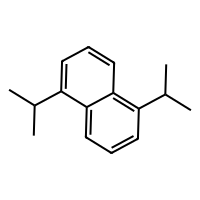

CC(C)c1cccc2c(C(C)C)cccc12


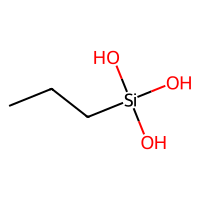

CCC[Si](O)(O)O


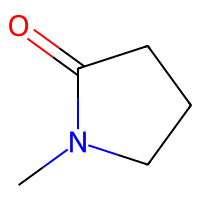

CN1CCCC1=O


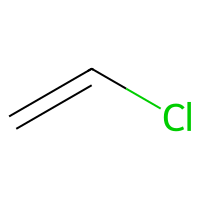

C=CCl


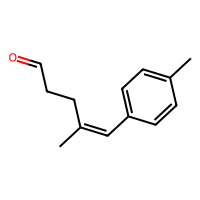

CC(=Cc1ccc(C)cc1)CCC=O


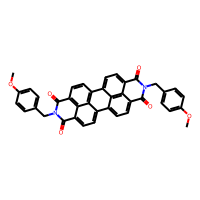

COc1ccc(CN2C(=O)c3ccc4c5ccc6c7c(ccc(c8ccc(c3c48)C2=O)c75)C(=O)N(Cc2ccc(OC)cc2)C6=O)cc1


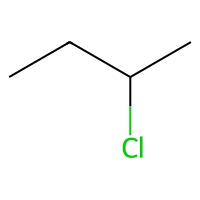

CCC(C)Cl


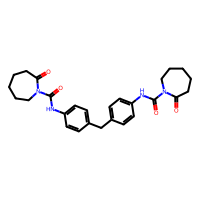

O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=O)cc2)cc1


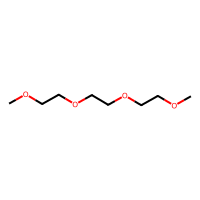

COCCOCCOCCOC


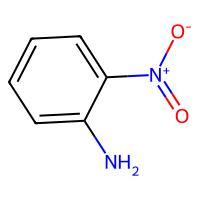

Nc1ccccc1[N+](=O)[O-]


In [10]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

def display_molecules_in_column(moldf, num_mols):
    for _, row in moldf.head(num_mols).iterrows():
        smi = row['SMILES']
        if smi is not None:
            mol = Chem.MolFromSmiles(smi)  # Create Mol object from SMILES
            if mol is not None:
                img = Draw.MolToImage(mol, size=(200, 200))
                display(img)
                print(smi)  # Prints the SMILES representation below the image

# Assuming 'df' is your DataFrame
# Display the first 10 molecules, each on a new row
display_molecules_in_column(moldf, 10)


## 3.  data distribution

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


outcomes=(np.unique(moldf['Outcome']))
le.fit(list(set(outcomes)))
y = le.transform( moldf['Outcome'] )



print ("Classes                          : ",(outcomes))
print ("Number of cpds in each class     : ",np.unique([len(y[y==smi]) for smi in y]))
print ("Total number of cpds             : ",len(y))

S = moldf['Outcome']
info = {}
for i,cls in enumerate(S.unique()):
    info.update({cls:i})
    S = S.replace(cls,i)

Classes                          :  ['0' '1']
Number of cpds in each class     :  [259 282]
Total number of cpds             :  541


{'0': 0, '1': 1}

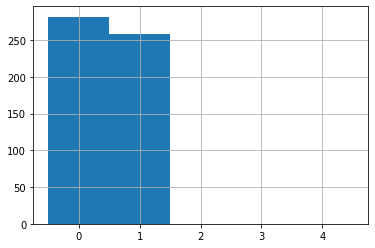

In [12]:
ax = S.hist(bins=np.arange(-0.5,5))
ax.set_xticks(range(0,5))
info

# 4. Morgan Descriptor

In [13]:
nBits = 1024
radius=2
useFeatures= False

calcfp = lambda mol: GetMorganFingerprintAsBitVect(mol,nBits=nBits,radius=radius, useFeatures=useFeatures)
moldf['Descriptors'] = moldf.Mol.apply(calcfp)

y= np.int32((S))
x = np.array(list(moldf['Descriptors']))

In [14]:
print(x)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## 5. hyperparameter tuning with grid search

In [15]:
#Random Forest
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
# Define your parameter grid as before
paramgrid = {
    "max_features": [
        x.shape[1], x.shape[1] // 2, x.shape[1] // 4, x.shape[1] // 12, x.shape[1] // 10,
        x.shape[1] // 7, x.shape[1] // 5, x.shape[1] // 3
    ],
    "n_estimators": [10, 100, 300, 500],
}

# Define the cross-validator as before
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=24)

# Define the scoring function using Cohen's Kappa Score with quadratic weighting
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# Everything else remains the same in your GridSearchCV initialization and fitting
model = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                     param_grid=paramgrid,
                     scoring=kappa_scorer,
                     cv=cv,
                     verbose=1,
                     n_jobs=1)  # Use -1 to use all cores

# Fit the model
model.fit(x, y)

# Get the best model
best_model = model.best_estimator_

# Optionally, fit the model with the best parameters (GridSearchCV automatically does this)
# best_model.fit(x, y)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, cohen_kappa_score

# Define your parameter grid
paramgrid = {
    "max_depth": [3, 5, 7, 10],  # Common choices for tree depth
    "n_estimators": [100, 200, 300],  # Number of trees
    "learning_rate": [0.01, 0.1, 0.2]  # Step size shrinkage used to prevent overfitting
}

# Define the cross-validator
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=24)

# Define the scoring function using Cohen's Kappa Score with quadratic weighting
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# Set up the GridSearchCV with XGBClassifier
model = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),  # use_label_encoder=False and eval_metric='mlogloss' to avoid warnings
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=cv,
    verbose=1,
    n_jobs=1  # Use -1 to use all cores
)

# Fit the model
model.fit(x, y)

# Get the best model
best_model = model.best_estimator_

# Optionally, fit the model with the best parameters (GridSearchCV automatically does this)
# best_model.fit(x, y)


Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [39]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, cohen_kappa_score

# Define your parameter grid
paramgrid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],  # Type of the kernel
    "gamma": ['scale', 'auto']  # Kernel coefficient
}

# Define the cross-validator
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=24)

# Define the scoring function using Cohen's Kappa Score with quadratic weighting
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# Set up the GridSearchCV with SVC
model = GridSearchCV(
    estimator=SVC(probability=True),  # probability=True if you need probability estimates
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=cv,
    verbose=1,
    n_jobs=1  # Use -1 to use all cores
)

# Fit the model
model.fit(x, y)

# Get the best model
best_model = model.best_estimator_

# Optionally, fit the model with the best parameters (GridSearchCV automatically does this)
# best_model.fit(x, y)


Fitting 2 folds for each of 32 candidates, totalling 64 fits


## 6. train with best model 

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Assume x, y, and best_model are defined elsewhere
#RF
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)

# Number of splits for cross-validation
n_splits = 5

# Prepare cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# Lists to store results for various metrics
accuracies = []
auc_scores = []
precisions = []
recalls = []
f1_scores = []
specificities = []
sensitivity_scores = []
ppvs = []
npvs = []
ccrs = []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# Cross-validation loop
for train_index, test_index in cv.split(x, y):
    # Split data
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model
    best_model.fit(X_train, y_train)
    
    # Predictions and predicted probabilities
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    
    # Metrics calculation
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))  # Binary class AUC
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Sensitivity and Specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    # PPV and NPV
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    ppvs.append(ppv)
    npvs.append(npv)
    
    # CCR
    ccr = calculate_ccr(sensitivity, specificity)
    ccrs.append(ccr)

# Displaying the results
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i+1}:")
    print(cm)
    
print(f'Overall CV Accuracy: {np.mean(accuracies)}')
print(f'Overall CV AUC: {np.mean(auc_scores)}')
print(f'Overall CV Precision: {np.mean(precisions)}')
print(f'Overall CV Recall (Sensitivity): {np.mean(sensitivity_scores)}')
print(f'Overall CV F1 Score: {np.mean(f1_scores)}')
print(f'Overall CV Specificity: {np.mean(specificities)}')
print(f'Overall CV PPV (Positive Predictive Value): {np.mean(ppvs)}')
print(f'Overall CV NPV (Negative Predictive Value): {np.mean(npvs)}')
print(f'Overall CV CCR (Correct Classification Rate): {np.mean(ccrs)}')


Confusion Matrix for Fold 1:
[[50  7]
 [24 28]]
Confusion Matrix for Fold 2:
[[37 20]
 [19 32]]
Confusion Matrix for Fold 3:
[[38 18]
 [27 25]]
Confusion Matrix for Fold 4:
[[41 15]
 [23 29]]
Confusion Matrix for Fold 5:
[[31 25]
 [16 36]]
Overall CV Accuracy: 0.6412674142031941
Overall CV AUC: 0.7042440069820101
Overall CV Precision: 0.6492069615477927
Overall CV Recall (Sensitivity): 0.5793363499245853
Overall CV F1 Score: 0.6065375963907564
Overall CV Specificity: 0.6981203007518797
Overall CV PPV (Positive Predictive Value): 0.6492069615477927
Overall CV NPV (Negative Predictive Value): 0.6442409628180905
Overall CV CCR (Correct Classification Rate): 0.6387283253382325


## 7. Save model

In [41]:
import joblib
joblib.dump(best_model, 'E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Modelo_inhalation_SVM_morgan_toxic_train_KU_50.pkl',compress=9)

['E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Modelo_inhalation_SVM_morgan_toxic_train_KU_50.pkl']